In [136]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans

Since its release, ChatGPT and similar AI tools have had a major impact on the public conscience, dramatically altering the text generation capabilities of the common user. It has had a deep and lasting impact on the work force and education, and countless think pieces have been published exploring the practical and ethical issues associated with ChatGPT specifically and AI in general.

This project explores over 50,000 Reddit comments on ChatGPT over a 2 month period, starting with its release at the end of November 2022 to the end of January 2023. The data includes four features: comment_id, comment_parent_id, comment_body, and subreddit, and was shared on Kaggle by Armita Razavi (https://www.kaggle.com/datasets/armitaraz/chatgpt-reddit).

The focus of this project to explore the nature of the language used in the comments to attempt to group the comments into categories. The word frequency will be calculated using sklearn's TFIDF Vectorizer. Following the preprocessing of the raw text, the comments will be categorized using sklearn's NMF model.

In [137]:
data = pd.read_csv("/Users/carrie/Downloads/chatgpt-reddit-comments.csv")
data.tail(20)

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
52396,16653,j4nf25b,t1_j4n5t0i,It doesn't have to be as extreme as a stupid c...,r/technology
52397,16654,j4jbhm0,t1_j4j72zf,I think it sucks that your job is in jeopardy....,r/technology
52398,16655,j4jd7lt,t1_j4j72zf,Just wanted to point out that if you lost your...,r/technology
52399,16656,j4j7gwu,t1_j4j62n5,"ha ha ha yeah, why do they deserve a job right...",r/technology
52400,16657,j4j9fzg,t1_j4j6qvu,"Yeah deepfakes, AI-assisted propaganda and god...",r/technology
52401,16658,j4nox78,t1_j4nf25b,>Social media platforms are already struggling...,r/technology
52402,16659,j4jed9j,t1_j4jbhm0,"Well, at least for the moment my job is not in...",r/technology
52403,16660,j4kk704,t1_j4j7gwu,That's it folks! Tech replacing jobs is unacce...,r/technology
52404,16661,j4jt92z,t1_j4j9fzg,Devices that cryptographically sign the images...,r/technology
52405,16662,j4jdfu8,t1_j4j9fzg,We're way past anything that can really stop i...,r/technology


The final 20 entries demomstrate some of the cleaning needed for the text. The text needs to be shifted into all lower case, and additional characters like numbers and symbols need to be removed. Furthermore, row 52406 has the comment '[deleted]' and row 53415 is null; deleted and null comments will need to be removed also.

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         52413 non-null  object
 1   comment_id         52415 non-null  object
 2   comment_parent_id  52415 non-null  object
 3   comment_body       52415 non-null  object
 4   subreddit          52415 non-null  object
dtypes: object(5)
memory usage: 2.0+ MB


In [139]:
data[data['comment_body'] == '[deleted]']

,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
164,164,izurnbd,t1_izupwur,[deleted],r/ChatGPT
334,334,iztkm8f,t3_zitw2v,[deleted],r/ChatGPT
436,436,j560mc6,t3_10gy5dx,[deleted],r/ChatGPT
471,471,j55td45,t3_10gy5dx,[deleted],r/ChatGPT
551,551,j564920,t3_10gy5dx,[deleted],r/ChatGPT
...,...,...,...,...,...
52142,16399,j3zbeo2,t1_j3z6rt0,[deleted],r/technology
52315,16572,j68v22r,t1_j68sh8s,[deleted],r/technology
52326,16583,j5o9z4r,t3_10k1fnr,[deleted],r/technology
52341,16598,j5obofe,t1_j5obe73,[deleted],r/technology


In [140]:
# The 661 [deleted] comments will be removed
data = data[data['comment_body'] != '[deleted]']

In [141]:
# The null comments will be removed
data = data.dropna()

In [142]:
# Text preprocessing to ensure lower case and remove numbers, symbols and empty comments
text = data.iloc[:,3]
empty_idx = []
for i in range(0, len(text)):
    text.iloc[i] = text.iloc[i].lower()
    text.iloc[i] = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text.iloc[i])
    if len(text.iloc[i]) == 0:
        empty_idx.append(i)

print('There are', len(empty_idx), 'empty comments. Those rows are removed.')

empty_idx.remove(45309)


There are 271 empty comments. Those rows are removed.


In [143]:
data = data.drop(empty_idx)

In [144]:
print('Cleaned comment_body text')
data.tail(20)

Cleaned comment_body text


,Unnamed: 0,comment_id,comment_parent_id,comment_body,subreddit
52394,16651,j4j6qvu,t1_j4j6kfn,its going to be a major issue they need to be ...,r/technology
52395,16652,j4rebmo,t1_j4rbcgp,they already have access to build better ai wi...,r/technology
52396,16653,j4nf25b,t1_j4n5t0i,it doesnt have to be as extreme as a stupid co...,r/technology
52397,16654,j4jbhm0,t1_j4j72zf,i think it sucks that your job is in jeopardy ...,r/technology
52398,16655,j4jd7lt,t1_j4j72zf,just wanted to point out that if you lost your...,r/technology
52399,16656,j4j7gwu,t1_j4j62n5,ha ha ha yeah why do they deserve a job right ...,r/technology
52400,16657,j4j9fzg,t1_j4j6qvu,yeah deepfakes aiassisted propaganda and god k...,r/technology
52401,16658,j4nox78,t1_j4nf25b,social media platforms are already struggling ...,r/technology
52402,16659,j4jed9j,t1_j4jbhm0,well at least for the moment my job is not in ...,r/technology
52403,16660,j4kk704,t1_j4j7gwu,thats it folks tech replacing jobs is unaccept...,r/technology


In [145]:
text = data.iloc[:,3]
length_text = []
for i in range(0, len(text)):
    length_text.append(len(text.iloc[i]))

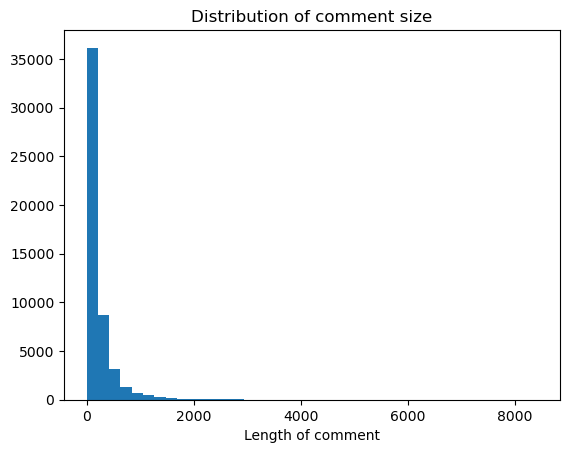

The longest comment is 8422 words.
The average comment length is 217.3 words.


In [146]:
plt.hist(length_text, bins=40)
plt.xlabel('Length of comment')
plt.title('Distribution of comment size')
plt.show()
print('The longest comment is', max(length_text), 'words.')
print('The average comment length is', round(np.mean(length_text), 1), 'words.')

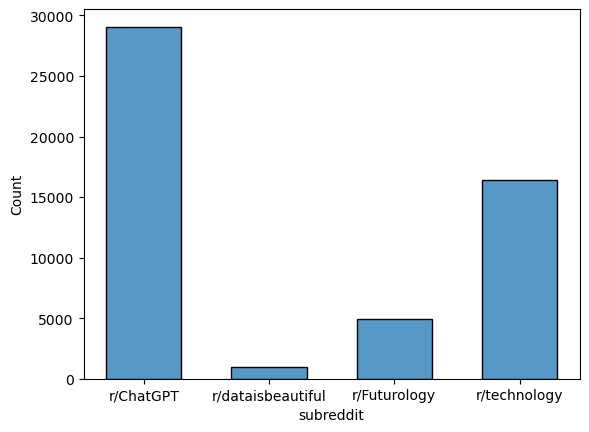

In [147]:
sns.histplot(data=data, x='subreddit', shrink = 0.6)
plt.show()

In [148]:
data.groupby(['comment_parent_id'])['comment_parent_id'].count().sort_values(ascending=False)

comment_parent_id
t3_107vs7i    239
t3_109g9gf    222
t3_10mias6    216
t3_ztd950     202
t3_10heg9p    202
             ... 
t1_j37nax1      1
t1_j37o9kk      1
t1_j37oboa      1
t1_j37odfu      1
t1_j3w9i2c      1
Name: comment_parent_id, Length: 22267, dtype: int64

# Text Processing

In [149]:
vect = TfidfVectorizer(stop_words='english', max_features = 20)
X = vect.fit_transform(text)
vect_features = vect.get_feature_names_out()
print(vect_features)
print(X.toarray())

['ai' 'chatgpt' 'dont' 'good' 'google' 'im' 'just' 'know' 'like' 'make'
 'need' 'people' 'really' 'thats' 'think' 'time' 'use' 'way' 'work'
 'write']
[[0.         0.         0.64534574 ... 0.         0.         0.        ]
 [0.         0.80844159 0.         ... 0.         0.         0.        ]
 [0.         0.55759841 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.67023574 ... 0.         0.         0.        ]]


In [150]:
tfid_features_mf20 = pd.DataFrame(X.toarray(), columns=vect_features)
print('Frequency of words, measured by TF-IDF, for the 20 most frequent words for each Reddit comment:')
tfid_features_mf20.shape

Frequency of words, measured by TF-IDF, for the 20 most frequent words for each Reddit comment:


(51481, 20)

Setting max_features to 20 allows for a readable list of the most frequent words after TF-IDF vectorization, but it is most likely insufficient for the NMF modelling. The initial NMF model will be based on TF_IDF of max_features=2000.

In [151]:
vect = TfidfVectorizer(stop_words='english', max_features = 2000)
X = vect.fit_transform(text)
vect_features = vect.get_feature_names_out()
vect_features

array(['10', '100', '1000', ..., 'youve', 'yup', 'zero'], dtype=object)

# NMF Modeling

In [152]:
def nmf_model(X, n_components):
    ''' Inputs a sparse matrix X and the number of components and perfoms the NMF modelling.
        Output are the arrays of feature and components.
    '''
    nmf = NMF(n_components = n_components, random_state = 23)
    W = nmf.fit_transform(X)
    H = nmf.components_
    return(W, H)


def topics(H, vect_features):
    ''' Inputs the array of components from the NMF modelling and the vector features from the Tfidf Vectorizer.
        The funciton iterates over the topics (number of components in the nmf_model), and prints 
        the 10 most frequent words.
    '''
    nmf_components_df = pd.DataFrame(H, columns=vect_features)
    for topic in range(nmf_components_df.shape[0]):
        tmp = nmf_components_df.iloc[topic]
        print(f'For topic {topic} the words with the highest value are:')
        print(tmp.nlargest(10))
        print('\n')
        
        
def predict_cat(W):
    ''' Inputs the features array from the NMF model and calculates the highest value for each text,
        assigning that topic. The function output is a list of predicted categories or topics.
    '''
    nmf_features_df = pd.DataFrame(W)
    predict_cat = []
    for index in range(data.shape[0]):
        category = nmf_features_df.iloc[index].idxmax()
        predict_cat.append(category)
    return predict_cat


In [153]:
# Initial NMF model with 5 categories
nmf = NMF(n_components = 5, random_state = 23)
W = nmf.fit_transform(X)
H = nmf.components_

/Users/carrie/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [154]:
# List of 10 most common words in each grouping
nmf_components_df = pd.DataFrame(H, columns=vect_features)
for topic in range(nmf_components_df.shape[0]):
    tmp = nmf_components_df.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')


For topic 0 the words with the highest value are:
just      1.977997
dont      1.319580
people    1.287629
im        1.042943
think     1.025560
know      0.950545
use       0.912008
good      0.869981
thats     0.860822
time      0.753793
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
chatgpt    4.141262
google     0.479627
ask        0.405466
write      0.223827
use        0.222472
search     0.215060
written    0.205150
using      0.204584
used       0.136748
gpt3       0.107129
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
ai           4.187954
human        0.353132
humans       0.208823
art          0.203421
generated    0.183653
open         0.166579
future       0.153480
going        0.143950
written      0.129547
jobs         0.116722
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
like      4.014947
sounds    0.665881
feel      0.282793
looks     0.262640
look      0.138096
sound     0.12429

In [155]:
# predicting the category for each comment
nmf_features_df = pd.DataFrame(W)
predict_cat = []
for index in range(data.shape[0]):
    category = nmf_features_df.iloc[index].idxmax()
    predict_cat.append(category)

In [156]:
df = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': predict_cat})
df.head()

,Comment,Subreddit,Category
0,ive been shocked for days now i dont need clic...,r/ChatGPT,0
1,i am so angry right now i just wasted my time...,r/ChatGPT,1
2,chatgpt karma whoring is here folks just when ...,r/ChatGPT,1
3,worked on me ngl,r/ChatGPT,0
4,certified 1010 mustsee moment it really did sh...,r/ChatGPT,0


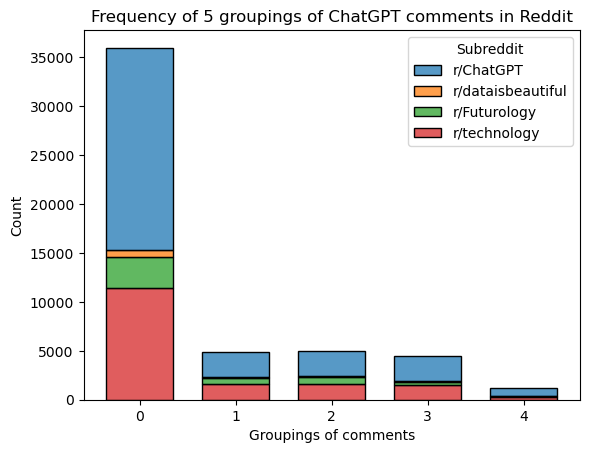

In [157]:
sns.histplot(data=df, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 5, step=1))
plt.xlabel('Groupings of comments')
plt.title('Frequency of 5 groupings of ChatGPT comments in Reddit')
plt.show()

In [158]:
# Exploring category 0, the most common grouping
print('Proportion of the comments in the first group', round(df[df['Category'] == 0].shape[0]/df.shape[0], 3))
df[df['Category'] == 0]

Proportion of the comments in the first group 0.699


,Comment,Subreddit,Category
0,ive been shocked for days now i dont need clic...,r/ChatGPT,0
3,worked on me ngl,r/ChatGPT,0
4,certified 1010 mustsee moment it really did sh...,r/ChatGPT,0
5,wow way to discover the most basic functionali...,r/ChatGPT,0
6,people on reddit seek the karma and the fameus...,r/ChatGPT,0
...,...,...,...
52410,scary thing is in this future text wont be tru...,r/technology,0
52411,read the tos youll thank me later,r/technology,0
52412,what am i missing here,r/technology,0
52413,what does chatgtp think of its own tos,r/technology,0


There appears to be some interesting connections between the topic ten most frequent words in each of the five categories, for example topic 1 seems to related using ChatGPT for writing, while topic 4 has a more edgy and possibly critical view of ChatGPT.

There is a clear imbalance in the distribution of the texts to each category, with nearly 70% of the comments in topic 0. It is worth exploring different numbers of components for the NMF, looking for a better balance between distribution of the comments and interesting thematic cohesion in the top ten word lists.

In [159]:
# Changing hyperparameters: 3 groups
nmf_3 = NMF(n_components = 3, random_state = 23)
W_3 = nmf_3.fit_transform(X)
H_3 = nmf_3.components_

/Users/carrie/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [160]:
nmf_components_df_3 = pd.DataFrame(H_3, columns=vect_features)

for topic in range(nmf_components_df_3.shape[0]):
    tmp = nmf_components_df_3.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
just      1.806238
like      1.766760
dont      1.176460
people    1.155926
im        0.947068
think     0.905430
know      0.852314
use       0.795634
thats     0.783733
good      0.780936
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
chatgpt    4.135389
google     0.503011
ask        0.416798
use        0.250859
write      0.231506
search     0.224093
using      0.211914
written    0.205648
used       0.143069
does       0.108642
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
ai           4.012356
human        0.340177
humans       0.202248
art          0.196044
generated    0.176350
open         0.161607
future       0.149653
going        0.147820
think        0.138972
people       0.128944
Name: 2, dtype: float64




In [161]:
nmf_features_df_3 = pd.DataFrame(W_3)
predict_cat_3 = []
for index in range(data.shape[0]):
    category = nmf_features_df_3.iloc[index].idxmax()
    predict_cat_3.append(category)

df_3 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': predict_cat_3})

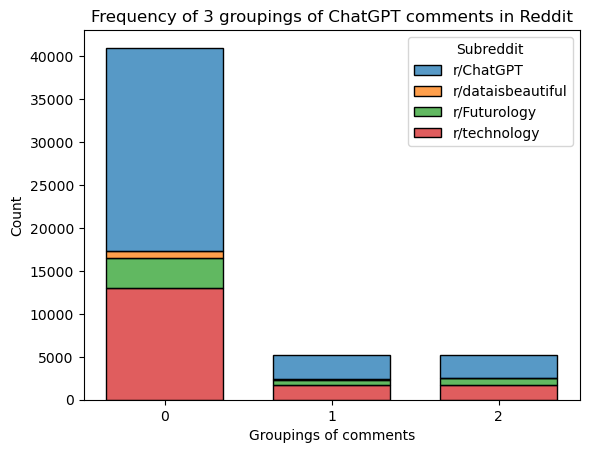

Proportion of the comments in the first group 0.797


In [162]:
sns.histplot(data=df_3, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 3, step=1))
plt.xlabel('Groupings of comments')
plt.title('Frequency of 3 groupings of ChatGPT comments in Reddit')
plt.show()

print('Proportion of the comments in the first group', round(df_3[df_3['Category'] == 0].shape[0]/df_3.shape[0], 3))

In [163]:
# Number of groupings = 10
nmf_10 = NMF(n_components = 10, random_state = 23)
W_10 = nmf_10.fit_transform(X)
H_10 = nmf_10.components_

/Users/carrie/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [164]:
nmf_components_df_10 = pd.DataFrame(H_10, columns=vect_features)

for topic in range(nmf_components_df_10.shape[0]):
    tmp = nmf_components_df_10.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
dont      1.952613
people    1.877797
think     1.434814
know      1.377480
use       1.281461
work      1.057897
make      0.976825
way       0.895097
time      0.876158
need      0.861846
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
chatgpt    4.187744
ask        0.424990
write      0.241240
written    0.211808
using      0.192533
use        0.161201
used       0.130122
gpt3       0.108321
model      0.096583
code       0.095771
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
ai           4.113488
human        0.337949
humans       0.198753
art          0.196278
generated    0.180876
open         0.162453
future       0.147145
going        0.137660
written      0.125787
jobs         0.105463
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
like      3.916257
sounds    0.647296
feel      0.278030
looks     0.255374
look      0.136848
sound     0.12154

In [165]:
nmf_features_df_10 = pd.DataFrame(W_10)
predict_cat_10 = []
for index in range(data.shape[0]):
    category = nmf_features_df_10.iloc[index].idxmax()
    predict_cat_10.append(category)

df_10 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': predict_cat_10})

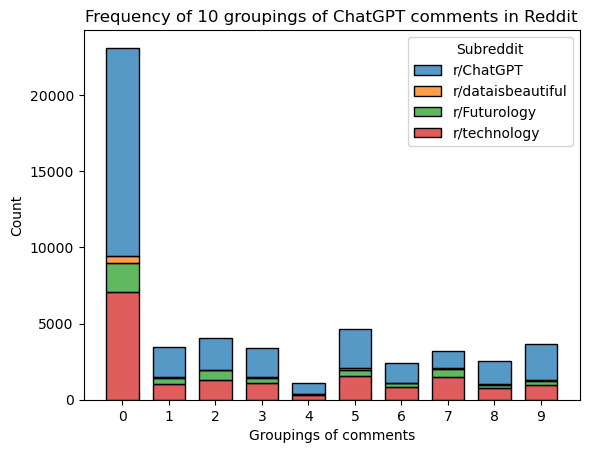

Proportion of the comments in the first group 0.449


In [166]:
sns.histplot(data=df_10, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 10, step=1))
plt.xlabel('Groupings of comments')
plt.title('Frequency of 10 groupings of ChatGPT comments in Reddit')
plt.show()

print('Proportion of the comments in the first group', round(df_10[df_10['Category'] == 0].shape[0]/df_10.shape[0], 3))

In [167]:
# Number of groupings = 20
nmf_20 = NMF(n_components = 20, random_state = 23)
W_20 = nmf_20.fit_transform(X)
H_20 = nmf_20.components_

/Users/carrie/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [168]:
nmf_components_df_20 = pd.DataFrame(H_20, columns=vect_features)

for topic in range(nmf_components_df_20.shape[0]):
    tmp = nmf_components_df_20.iloc[topic]
    print(f'For topic {topic} the words with the highest value are:')
    print(tmp.nlargest(10))
    print('\n')

For topic 0 the words with the highest value are:
work      1.901844
time      1.744099
way       1.715741
need      1.182001
really    1.140447
write     1.108230
does      0.916581
better    0.911485
things    0.903296
ive       0.876943
Name: 0, dtype: float64


For topic 1 the words with the highest value are:
chatgpt    4.231058
written    0.195774
using      0.145447
gpt3       0.102817
write      0.094920
used       0.087934
openai     0.087217
version    0.077416
post       0.060410
model      0.058291
Name: 1, dtype: float64


For topic 2 the words with the highest value are:
ai           4.024167
human        0.293293
art          0.184416
humans       0.181130
generated    0.170239
open         0.152792
future       0.130576
written      0.105987
going        0.104541
jobs         0.093178
Name: 2, dtype: float64


For topic 3 the words with the highest value are:
like      3.815251
sounds    0.631128
feel      0.268627
looks     0.247366
look      0.129999
sound     0.11593

In [169]:
nmf_features_df_20 = pd.DataFrame(W_20)
predict_cat_20 = []
for index in range(data.shape[0]):
    category = nmf_features_df_20.iloc[index].idxmax()
    predict_cat_20.append(category)

df_20 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': predict_cat_20})

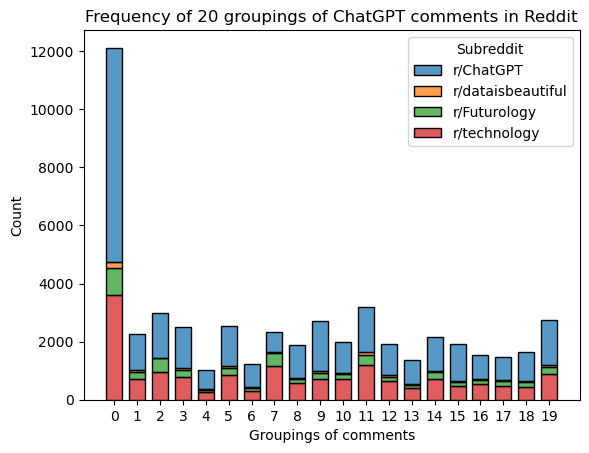

Proportion of the comments in the first group (the largest) 0.235


In [184]:
sns.histplot(data=df_20, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 20, step=1))
plt.xlabel('Groupings of comments')
plt.title('Frequency of 20 groupings of ChatGPT comments in Reddit')
plt.show()

print('Proportion of the comments in the first group (the largest)', round(df_20[df_20['Category'] == 0].shape[0]/df_20.shape[0], 3))

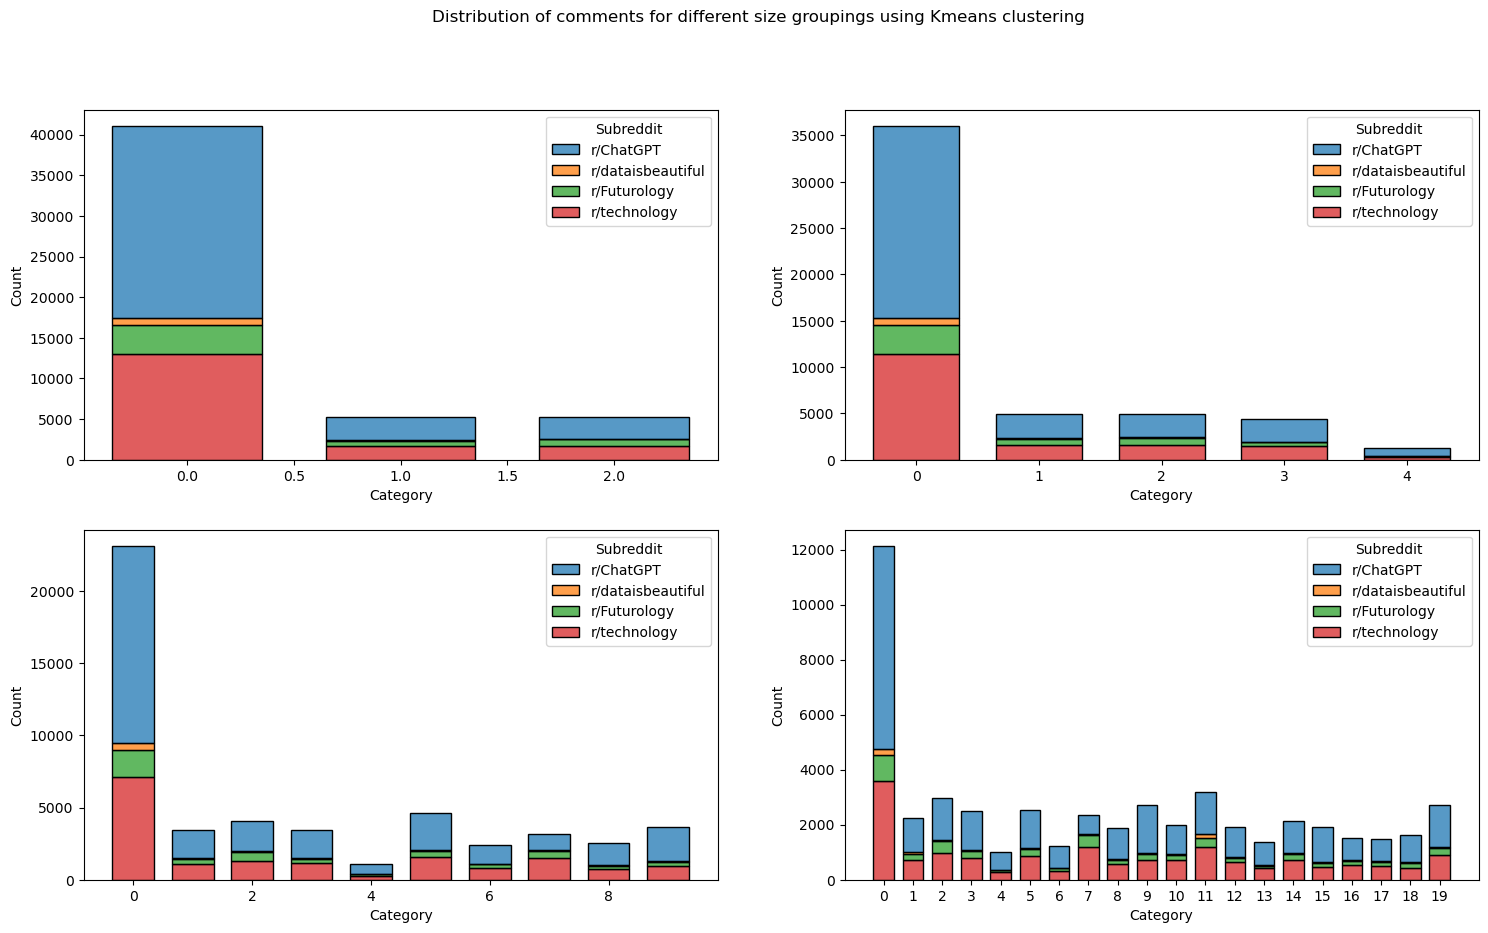

In [171]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distribution of comments for different size groupings using Kmeans clustering')
 
sns.histplot(ax=axes[0, 0], data=df_3, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 3, step=1))
sns.histplot(ax=axes[0, 1], data=df, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 5, step=1))
sns.histplot(ax=axes[1, 0], data=df_10, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 10, step=1))
sns.histplot(ax=axes[1, 1], data=df_20, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Exploring 4 different numbers of categories, there is still a clear concetration in the first topic, although the percentage of the total number of comments decreases from nearly 80% with 3 topics to 24% with 20 topics. There is still some coherence in the top 10 words which would be worthy of further investigating

# Alternative unsupervised model: Kmeans clustering
Kmeans clustering, a potential alternative to NMF, will also use the TF-IDF vectorization for max_features = 2000, with the number of clusters as 3, 5, 10, and 20 to compare with NMF.

In [172]:
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(X)
df_km3 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': kmeans_3.labels_})

In [173]:
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(X)
df_km5 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': kmeans_5.labels_})

In [174]:
kmeans_10 = KMeans(n_clusters=10)
kmeans_10.fit(X)
df_km10 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': kmeans_10.labels_})

In [175]:
kmeans_20 = KMeans(n_clusters=20)
kmeans_20.fit(X)
df_km20 = pd.DataFrame({'Comment': text, 'Subreddit': data['subreddit'], 'Category': kmeans_20.labels_})

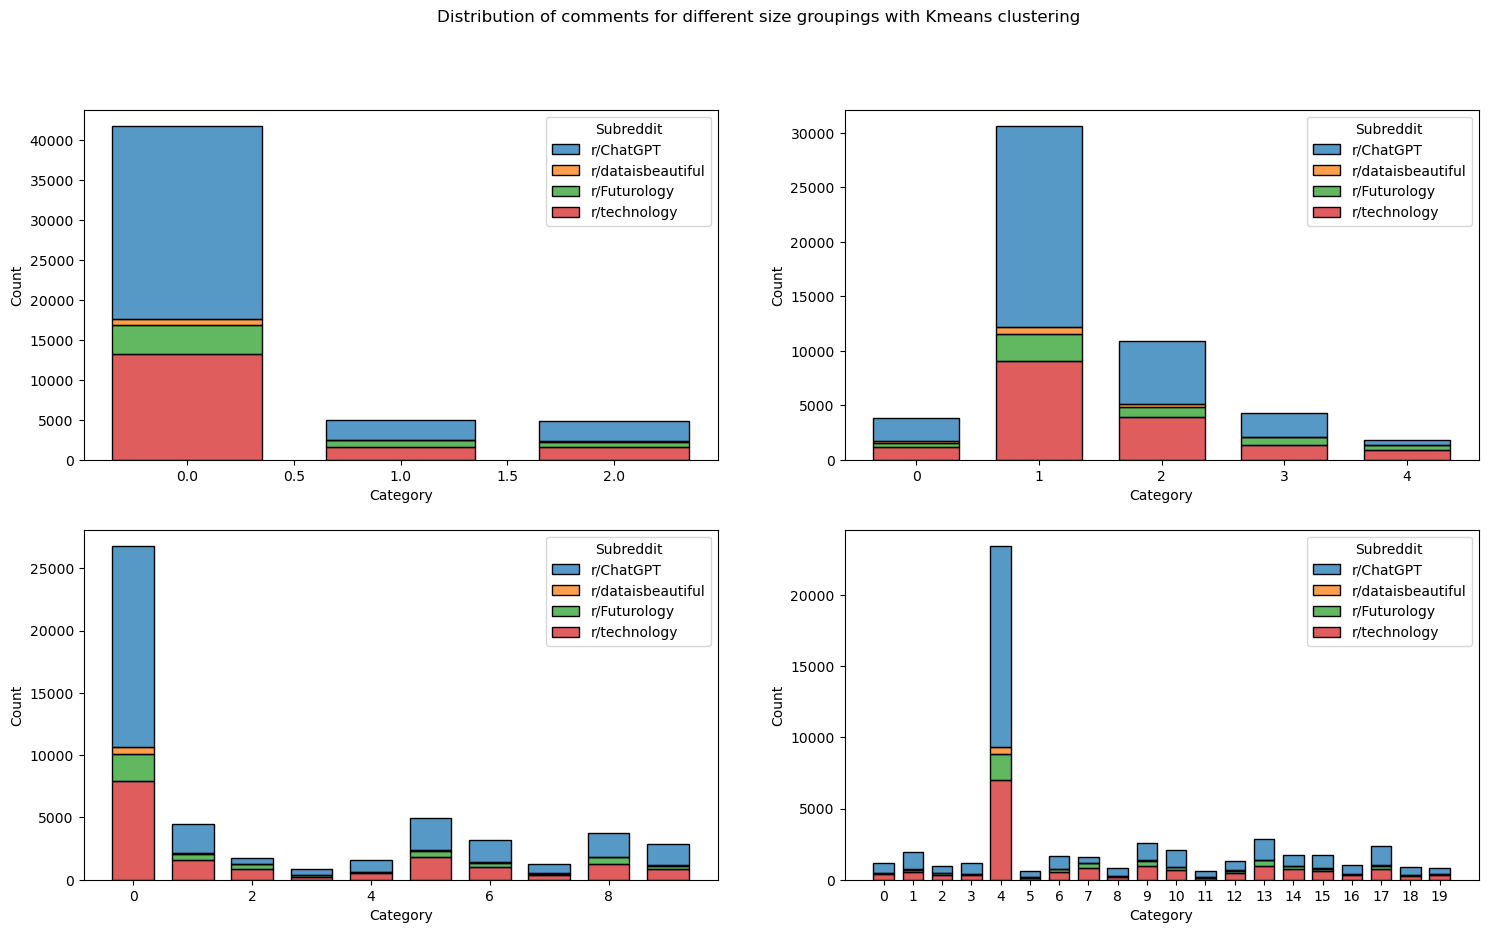

In [176]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distribution of comments for different size groupings with Kmeans clustering')
 
sns.histplot(ax=axes[0, 0], data=df_km3, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 3, step=1))
sns.histplot(ax=axes[0, 1], data=df_km5, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 5, step=1))
sns.histplot(ax=axes[1, 0], data=df_km10, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 10, step=1))
sns.histplot(ax=axes[1, 1], data=df_km20, x='Category', binwidth=0.5, hue='Subreddit', multiple='stack', discrete='True', shrink=0.7)
plt.xticks(np.arange(0, 20, step=1))
plt.show()

Like the NMF modeling, one category is dramatically larger than the others, however, with Kmeans clustering there appears to be greater variation between the remaining categories.

One of the disadvantages of the Kmeans clustering is there is not a direct way to extract the most common words in each grouping, as we could do with NMF. 
Using the the Kmeans model with 10 clusters, we can generate the 10 most common words by extracting the texts for each cluster and processing them with TFIDFVectorizer (max_features=10).

In [190]:
for topic in range(0, 10):
    df = df_km10[df_km10['Category'] == topic]
    text_km = df.iloc[:,0]
    vect = TfidfVectorizer(stop_words='english', max_features = 10)
    X = vect.fit_transform(text_km)
    print(f'For topic {topic} the words with the highest value are:')
    print(vect.get_feature_names_out())
    

For topic 0 the words with the highest value are:
['good' 'im' 'like' 'make' 'think' 'time' 'use' 'way' 'work' 'write']
For topic 1 the words with the highest value are:
['dont' 'im' 'just' 'know' 'like' 'lol' 'make' 'people' 'think' 'work']
For topic 2 the words with the highest value are:
['ai' 'chatgpt' 'dont' 'google' 'just' 'like' 'people' 'results' 'search'
 'use']
For topic 3 the words with the highest value are:
['ai' 'bot' 'chat' 'dont' 'gpt' 'im' 'just' 'like' 'use' 'write']
For topic 4 the words with the highest value are:
['ai' 'chatgpt' 'good' 'im' 'just' 'like' 'people' 'thats' 'think' 'use']
For topic 5 the words with the highest value are:
['chatgpt' 'dont' 'im' 'just' 'like' 'make' 'people' 'think' 'time' 'use']
For topic 6 the words with the highest value are:
['ai' 'ask' 'chatgpt' 'just' 'like' 'people' 'use' 'using' 'way' 'write']
For topic 7 the words with the highest value are:
['ai' 'chatgpt' 'dont' 'im' 'just' 'like' 'make' 'people' 'use' 'want']
For topic 8 the

With simple observation, these lists of top ten words seems to be less informative than the NMF models. There is a great deal of repetition of the common words like 'just', 'like' and 'make', which don't help to distill a theme to the topic lists.

In [188]:
# measuring the run time of KMeans clustering and NMF, 10 clusters/components each.
st = time.time()
kmeans_10 = KMeans(n_clusters=10, random_state = 123)
kmeans_10.fit(X)
kmeans_10.labels_
et = time.time()
print('Run time for Kmeans is', round(et-st, 3))

Run time for Kmeans is 0.155


In [189]:
st = time.time()
nmf_10 = NMF(n_components = 10, random_state = 123)
W_10 = nmf_10.fit_transform(X)
H_10 = nmf_10.components_
et = time.time()
print('Run time for NMF is', round(et-st, 3))

Run time for NMF is 0.078


/Users/carrie/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


The run time for NMF is approximately half of Kmeans, a significant difference. Thus with the richer quality of language in the top ten lists and significantly faster run time, NMF appears to be a better choice for the unsupervised learning task of grouping the Reddit comments on Chat GPT.
Future possiblities for analyze would to be use alternate techniques for pre-processing the texts, for example using a different list of stop words or removing related tokens (for example in topic 1 of the NMF n_components=5 example there is 'use', 'using' and 'used', and 'write' and 'written'). In addition, other algorithims for measuring the frequency of words, such as Word2Vec or Bag of Words, could replace TF-IDF.

# References
for text cleaning: https://monkeylearn.com/blog/text-cleaning/